# 01_prepare_cassava

**Objective:**  
Prepare the *Cassava Leaf Disease Classification* dataset for model training by:
- Reading labels from `train.csv`
- Creating stratified train/validation/test splits
- Organizing images into `/data/processed/cassava/`
- Exporting metadata (`labels.csv`)


In [ ]:
import os
import shutil
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import json

# Use your actual dataset path
BASE_DIR = Path(r"C:\Users\User\Desktop\Data Science\Projects\crop-disease-detection\data\raw\cassava-leaf-disease-classification")
TRAIN_DIR = BASE_DIR / "train_images"
PROCESSED_DIR = Path(r"C:\Users\User\Desktop\Data Science\Projects\crop-disease-detection\data\processed\cassava")

# Ensure processed directories exist
(PROCESSED_DIR / "train").mkdir(parents=True, exist_ok=True)
(PROCESSED_DIR / "val").mkdir(parents=True, exist_ok=True)
(PROCESSED_DIR / "test").mkdir(parents=True, exist_ok=True)

print("✅ Base directory:", BASE_DIR)
print("Training images:", len(list(TRAIN_DIR.glob('*.jpg'))))


✅ Base directory: C:\Users\User\Desktop\Data Science\Projects\crop-disease-detection\data\raw\cassava-leaf-disease-classification
Training images: 21397


Load Labels and Mapping

In [3]:
# Load training metadata
train_df = pd.read_csv(BASE_DIR / "train.csv")

# Load class mapping from JSON file
with open(BASE_DIR / "label_num_to_disease_map.json") as f:
    label_map = json.load(f)
label_map = {int(k): v for k, v in label_map.items()}

# Add readable class names
train_df["label_name"] = train_df["label"].map(label_map)
print("✅ Unique classes:", train_df["label_name"].nunique())
train_df.head()


✅ Unique classes: 5


,image_id,label,label_name
0,1000015157.jpg,0,Cassava Bacterial Blight (CBB)
1,1000201771.jpg,3,Cassava Mosaic Disease (CMD)
2,100042118.jpg,1,Cassava Brown Streak Disease (CBSD)
3,1000723321.jpg,1,Cassava Brown Streak Disease (CBSD)
4,1000812911.jpg,3,Cassava Mosaic Disease (CMD)


Stratified Split

In [4]:
# 80/10/10 split (train/val/test) using stratification on label
train_df, temp_df = train_test_split(train_df, test_size=0.20, stratify=train_df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df["label"], random_state=42)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")


Train: 17117 | Val: 2140 | Test: 2140


Copy Images into Split Folders

In [5]:
def copy_images(df_split, split_name):
    split_dir = PROCESSED_DIR / split_name
    for _, row in tqdm(df_split.iterrows(), total=len(df_split), desc=f"Copying {split_name} images"):
        class_dir = split_dir / str(row["label_name"])
        class_dir.mkdir(parents=True, exist_ok=True)
        src_path = TRAIN_DIR / row["image_id"]
        dst_path = class_dir / row["image_id"]
        if src_path.exists():
            shutil.copy(src_path, dst_path)

copy_images(train_df, "train")
copy_images(val_df, "val")
copy_images(test_df, "test")


Copying test images: 100%|██████████| 2140/2140 [00:09<00:00, 218.40it/s]


Save metadata

In [6]:
# Combine all splits and save for reproducibility
train_df["split"] = "train"
val_df["split"] = "val"
test_df["split"] = "test"

full_df = pd.concat([train_df, val_df, test_df], axis=0)
meta_path = PROCESSED_DIR / "labels.csv"
full_df.to_csv(meta_path, index=False)
print("✅ Metadata saved to:", meta_path)


✅ Metadata saved to: C:\Users\User\Desktop\Data Science\Projects\crop-disease-detection\data\processed\cassava\labels.csv


Sanity check

In [7]:
# Count images per split and class
summary = (
    full_df.groupby(["split", "label_name"])
    .size()
    .reset_index(name="count")
    .pivot(index="label_name", columns="split", values="count")
    .fillna(0)
    .astype(int)
)

summary["total"] = summary.sum(axis=1)
summary


split,test,train,val,total
label_name,,,,
Cassava Bacterial Blight (CBB),109,870,108,1087
Cassava Brown Streak Disease (CBSD),219,1751,219,2189
Cassava Green Mottle (CGM),238,1909,239,2386
Cassava Mosaic Disease (CMD),1316,10526,1316,13158
Healthy,258,2061,258,2577


Class Distribution

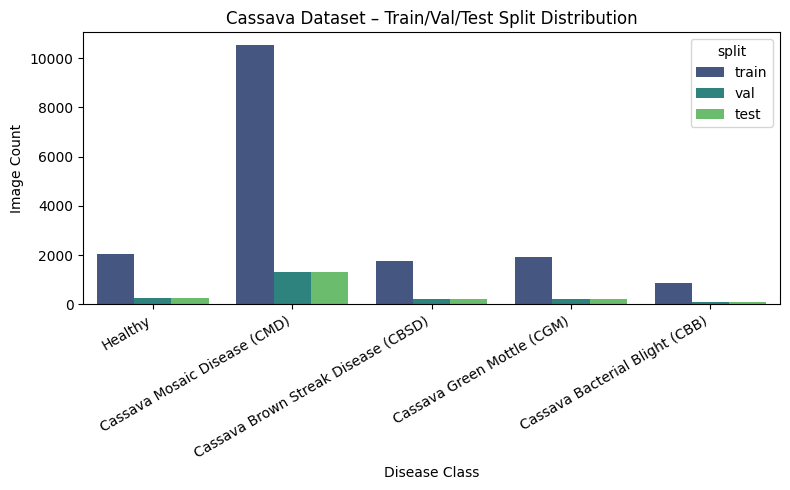

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.countplot(data=full_df, x="label_name", hue="split", palette="viridis")
plt.title("Cassava Dataset – Train/Val/Test Split Distribution")
plt.xticks(rotation=30, ha="right")
plt.xlabel("Disease Class")
plt.ylabel("Image Count")
plt.tight_layout()
plt.show()


A lot of imbalance

## Summary

- Cassava dataset successfully split and organized.  
- Stratified 80/10/10 split ensures balanced classes across sets.  
- All processed data saved to:
